# Description

Explore research backtest results.

**Note**: use `dataflow/model/notebooks/Master_backtest_analysis_param_sweep.ipynb` for standard backtest analysis.
This notebook is used for free-form analysis and hypotheses testing, and thus is not as strictly maintained.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging
import os

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint
import oms.broker.ccxt.ccxt_utils as obccccut

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-e0de3fdf-a1ec-47b8-ab67-9c3a14c098f7.json'
INFO  # Git
  branch_name='CMTask8038_remove_saving_portfolio_from_toy_backtest_analyzer'
  hash='9d43e4bbe'
  # Last commits:
    * 9d43e4bbe Danya Tikhomirov CMTask8057: Fix backtest notebook test (#8060)                    (25 minutes ago) Thu Apr 25 12:35:47 2024  (HEAD -> CMTask8038_remove_saving_portfolio_from_toy_backtest_analyzer, origin/master, origin/HEAD, origin/CMTask8038_remove_saving_portfolio_from_toy_backtest_analyzer, master)
    * 17a5b3226 Samarth KaPatel CmampTask7895_Automate_filing_experiments_reports (#7950)         (  18 hours ago) Wed Apr 24 19:16:14 2024  (origin/CmTask8054_Update_input_test_data_for_Test_run_system_reconciliation_notebook)
    * 0ab5a311e Sameep Pote CmTask7933_Add_alerts_to_the_scheduled_monitoring_flow_1 (#8006)  (  19 hours ago) Wed Apr 24 18:12:20 2024           
# Machine info
  syst

# Build the config dict

In [4]:
# Get config from env when running the notebook via the `run_notebook.py` script.
default_config = cconfig.get_config_from_env()
if default_config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Build default config.
    amp_dir = hgit.get_amp_abs_path()
    dir_name = os.path.join(
        amp_dir,
        "/shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.6T.2023-06-01_2024-01-31.ins.run0/tiled_results",
    )
    # Create a subfolder to store portfolio metrics.
    # The subfolder is marked by the datetime of the run, e.g.
    # "build_tile_configs.C11a.ccxt_v8_1-all.5T.2023-01-01_2024-03-20.ins.run0/portfolio_dfs/20240326_131724".
    # TODO(Danya): Factor out into a function.
    default_config_dict = {
        "dir_name": dir_name,
        "start_date": datetime.date(2024, 1, 1),
        "end_date": datetime.date(2024, 1, 31),
        "asset_id_col": "asset_id",
        "pnl_resampling_frequency": "D",
        "rule": "6T",
        "im_client_config": {
            "vendor": "ccxt",
            "universe_version": "v8.1",
            "root_dir": "s3://cryptokaizen-data.preprod/v3",
            "partition_mode": "by_year_month",
            "dataset": "ohlcv",
            "contract_type": "futures",
            "data_snapshot": "",
            "aws_profile": "ck",
            "version": "v1_0_0",
            "download_universe_version": "v8",
            "tag": "downloaded_1min",
            "download_mode": "periodic_daily",
            "downloading_entity": "airflow",
            "resample_1min": False,
        },
        "annotate_forecasts_kwargs": {
            "style": "longitudinal",
            "quantization": 30,
            "liquidate_at_end_of_day": False,
            "initialize_beginning_of_day_trades_to_zero": False,
            "burn_in_bars": 3,
            "compute_extended_stats": True,
            "target_dollar_risk_per_name": 1.0,
            "modulate_using_prediction_magnitude": False,
            "prediction_abs_threshold": 0.3,
        },
        "forecast_evaluator_kwargs": {
            "price_col": "open",
            "volatility_col": "garman_klass_vol",
            "prediction_col": "feature",
        },
        "bin_annotated_portfolio_df_kwargs": {
            "proportion_of_data_per_bin": 0.2,
            "normalize_prediction_col_values": False,
        },
        "load_all_tiles_in_memory": True,
        "sweep_param": {
            "keys": (
                "column_names",
                "price_col",
            ),
            "values": [
                "open",
            ],
        },
    }
    # Add asset_id_to_share_decimals based on the `quantization` parameter.
    if not default_config_dict["annotate_forecasts_kwargs"]["quantization"]:
        asset_id_to_share_decimals = obccccut.get_asset_id_to_share_decimals(
            "amount_precision"
        )
        default_config_dict["annotate_forecasts_kwargs"][
            "asset_id_to_share_decimals"
        ] = asset_id_to_share_decimals
    else:
        default_config_dict["annotate_forecasts_kwargs"][
            "asset_id_to_share_decimals"
        ] = None
    # Build config from dict.
    default_config = cconfig.Config().from_dict(default_config_dict)
print(default_config)

INFO  Using hardwired config
dir_name: /shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.6T.2023-06-01_2024-01-31.ins.run0/tiled_results
start_date: 2024-01-01
end_date: 2024-01-31
asset_id_col: asset_id
pnl_resampling_frequency: D
rule: 6T
im_client_config: 
  vendor: ccxt
  universe_version: v8.1
  root_dir: s3://cryptokaizen-data.preprod/v3
  partition_mode: by_year_month
  dataset: ohlcv
  contract_type: futures
  data_snapshot: 
  aws_profile: ck
  version: v1_0_0
  download_universe_version: v8
  tag: downloaded_1min
  download_mode: periodic_daily
  downloading_entity: airflow
  resample_1min: False
annotate_forecasts_kwargs: 
  style: longitudinal
  quantization: 30
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  burn_in_bars: 3
  compute_extended_stats: True
  target_dollar_risk_per_name: 1.0
  modulate_using_prediction_magnitude: False
  prediction_abs_threshold: 0.3
  asset_id_to_share_decimals: None
forecast_evaluator_k

# Load tiled results

## Report tile stats

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    default_config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1020313424,2,8,8,40.9 MB
1106736216,2,8,8,41.0 MB
1669260535,2,8,8,41.3 MB
1670436375,2,8,8,40.9 MB
1775391824,2,8,8,40.7 MB
1813442534,2,8,8,41.3 MB
1871387621,2,8,8,40.6 MB
2200033667,2,8,8,40.4 MB
2237530510,2,8,8,40.6 MB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids      size
year month                       
2023 6               23  114.6 MB
     7               25  120.1 MB
     8               25  128.8 MB
     9               25  124.7 MB
     10              25  129.1 MB
     11              25  125.1 MB
     12              25  129.6 MB
2024 1               25  129.5 MB

In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1020313424,
 1106736216,
 1669260535,
 1670436375,
 1775391824,
 1813442534,
 1871387621,
 2200033667,
 2237530510,
 2470395105,
 2499295598,
 2506553600,
 2565005155,
 2601760471,
 2971863517,
 2989693852,
 3304664847,
 3323452427,
 3326458212,
 4417972573,
 5141755262,
 6009830573,
 6335759645,
 8717633868,
 8968126878]

## Load tile data

In [9]:
if default_config["load_all_tiles_in_memory"]:
    asset_ids_to_load = asset_ids
else:
    asset_ids_to_load = asset_ids[0:1]
asset_batch_size = len(asset_ids_to_load)
cols = None
#
asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        default_config["dir_name"],
        asset_ids_to_load,
        default_config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
tile_df = dtfmod.process_parquet_read_df(
    asset_tile, default_config["asset_id_col"]
)

In [11]:
tile_df.columns.levels[0].to_list()

['close',
 'close_mean',
 'feature',
 'garman_klass_vol',
 'high',
 'low',
 'month',
 'open',
 'p1',
 'p1.c',
 'p1.c.xs_adj',
 'p1.c.xs_adj.c',
 'p2',
 'p2.c',
 'p2.c.xs_adj',
 'p2.c.xs_adj.c',
 'p3',
 'p_diff',
 'p_diff.c',
 'p_diff.c.xs_adj',
 'p_diff.c.xs_adj.c',
 'p_est_mean',
 'p_lr',
 'p_lr.c',
 'p_lr.c.xs_adj',
 'p_lr.c.xs_adj.c',
 'q1',
 'q1.c',
 'q1.c.xs_adj',
 'q1.c.xs_adj.c',
 'q2',
 'q2.c',
 'q2.c.xs_adj',
 'q2.c.xs_adj.c',
 'q3',
 'q3.c',
 'q3.c.xs_adj',
 'q3.c.xs_adj.c',
 'q4',
 'q5',
 'q6',
 'q_mv',
 'q_mv_adj',
 'q_mv_os',
 'r1',
 'r1.c',
 'r1.c.xs_adj',
 'r1.c.xs_adj.c',
 'r2',
 'r2.c',
 'r2.c.xs_adj',
 'r2.c.xs_adj.c',
 'r3',
 'r4',
 'r4.c',
 'r4.c.xs_adj',
 'r4.c.xs_adj.c',
 'r5',
 'r5.c',
 'r5.c.xs_adj',
 'r5.c.xs_adj.c',
 'r6',
 'r6.c',
 'r6.c.xs_adj',
 'r6.c.xs_adj.c',
 'r_est',
 'r_est.c',
 'r_est.c.xs_adj',
 'r_est.c.xs_adj.c',
 'r_lr',
 'r_lr.c',
 'r_lr.c.xs_adj',
 'r_lr.c.xs_adj.c',
 'sqrt_q_mv',
 'sqrt_q_mv_adj',
 'sqrt_q_mv_os',
 'v_ld',
 'v_ld.c',
 'v_ld.c.

In [12]:
tile_df.head(3)

close                                                                                                                                                                                                                                                                         close_mean                                                                                                                                                                                                                                                                                feature                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                           \
asset_id                  1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534  1871387621 2200033667 2237530510  2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852  3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868  8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878       1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2023-06-01 00:00:00+00:00     1.3821     0.7277     2.5205      9.980     0.5390    0.13322      634.8      11.46     20.809     145.86     0.0846      7.252     0.5997      6.475      1.232        NaN     113.20     18.006     0.9739     2.0910     1.1599        NaN      4.676     14.099     306.90   1.383217   0.727617   2.522867   9.983000   0.539467   0.133135  634.833333  11.458333  20.812167  145.970000   0.084567   7.252833   0.599850   6.476000   1.233000        NaN  113.186667  18.002333   0.973950   2.089917   1.160617        NaN   4.674667  14.106500  306.921667   0.493161   0.801897   1.100688   0.468634   0.379328  -1.021384   0.817968   1.527676  -0.369468   0.362470   0.899875  -0.797428   0.072698  -1.300463  -1.121546        NaN  -1.587029  -1.537099   0.675034  -0.771554   0.912549        NaN  -0.786638   1.273821  -0.456692         0.001584   0.001772   0.001977   0.000730   0.001537   0.001805   0.000521   0.001234   0.000847   0.001484   0.002399   0.001522   
2023-06-01 00:06:00+00:00     1.3794     0.7251

# Compute and save portfolio bar metrics

In [13]:
# Get configs sweeping over parameter.
config_dict = dtfmod.build_research_backtest_analyzer_config_sweep(default_config)
print(config_dict.keys())

dict_keys(['column_names:price_col = open'])


In [14]:
portfolio_df_dict = {}
bar_metrics_dict = {}
for key, config in config_dict.items():
    if config["load_all_tiles_in_memory"]:
        fep = dtfmod.ForecastEvaluatorFromPrices(
            **config["forecast_evaluator_kwargs"].to_dict(),
        )
        portfolio_df, bar_metrics = fep.annotate_forecasts(
            tile_df,
            **config["annotate_forecasts_kwargs"].to_dict(),
        )
    else:
        portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
            config["dir_name"],
            config["start_date"],
            config["end_date"],
            config["asset_id_col"],
            config["forecast_evaluator_kwargs"]["price_col"],
            config["forecast_evaluator_kwargs"]["volatility_col"],
            config["forecast_evaluator_kwargs"]["prediction_col"],
            asset_ids=None,
            annotate_forecasts_kwargs=config[
                "annotate_forecasts_kwargs"
            ].to_dict(),
            return_portfolio_df=True,
        )
    portfolio_df_dict[key] = portfolio_df
    bar_metrics_dict[key] = bar_metrics
portfolio_stats_df = pd.concat(bar_metrics_dict, axis=1)

INFO  spread is `None`; imputing spread_lower_bound=0.000100


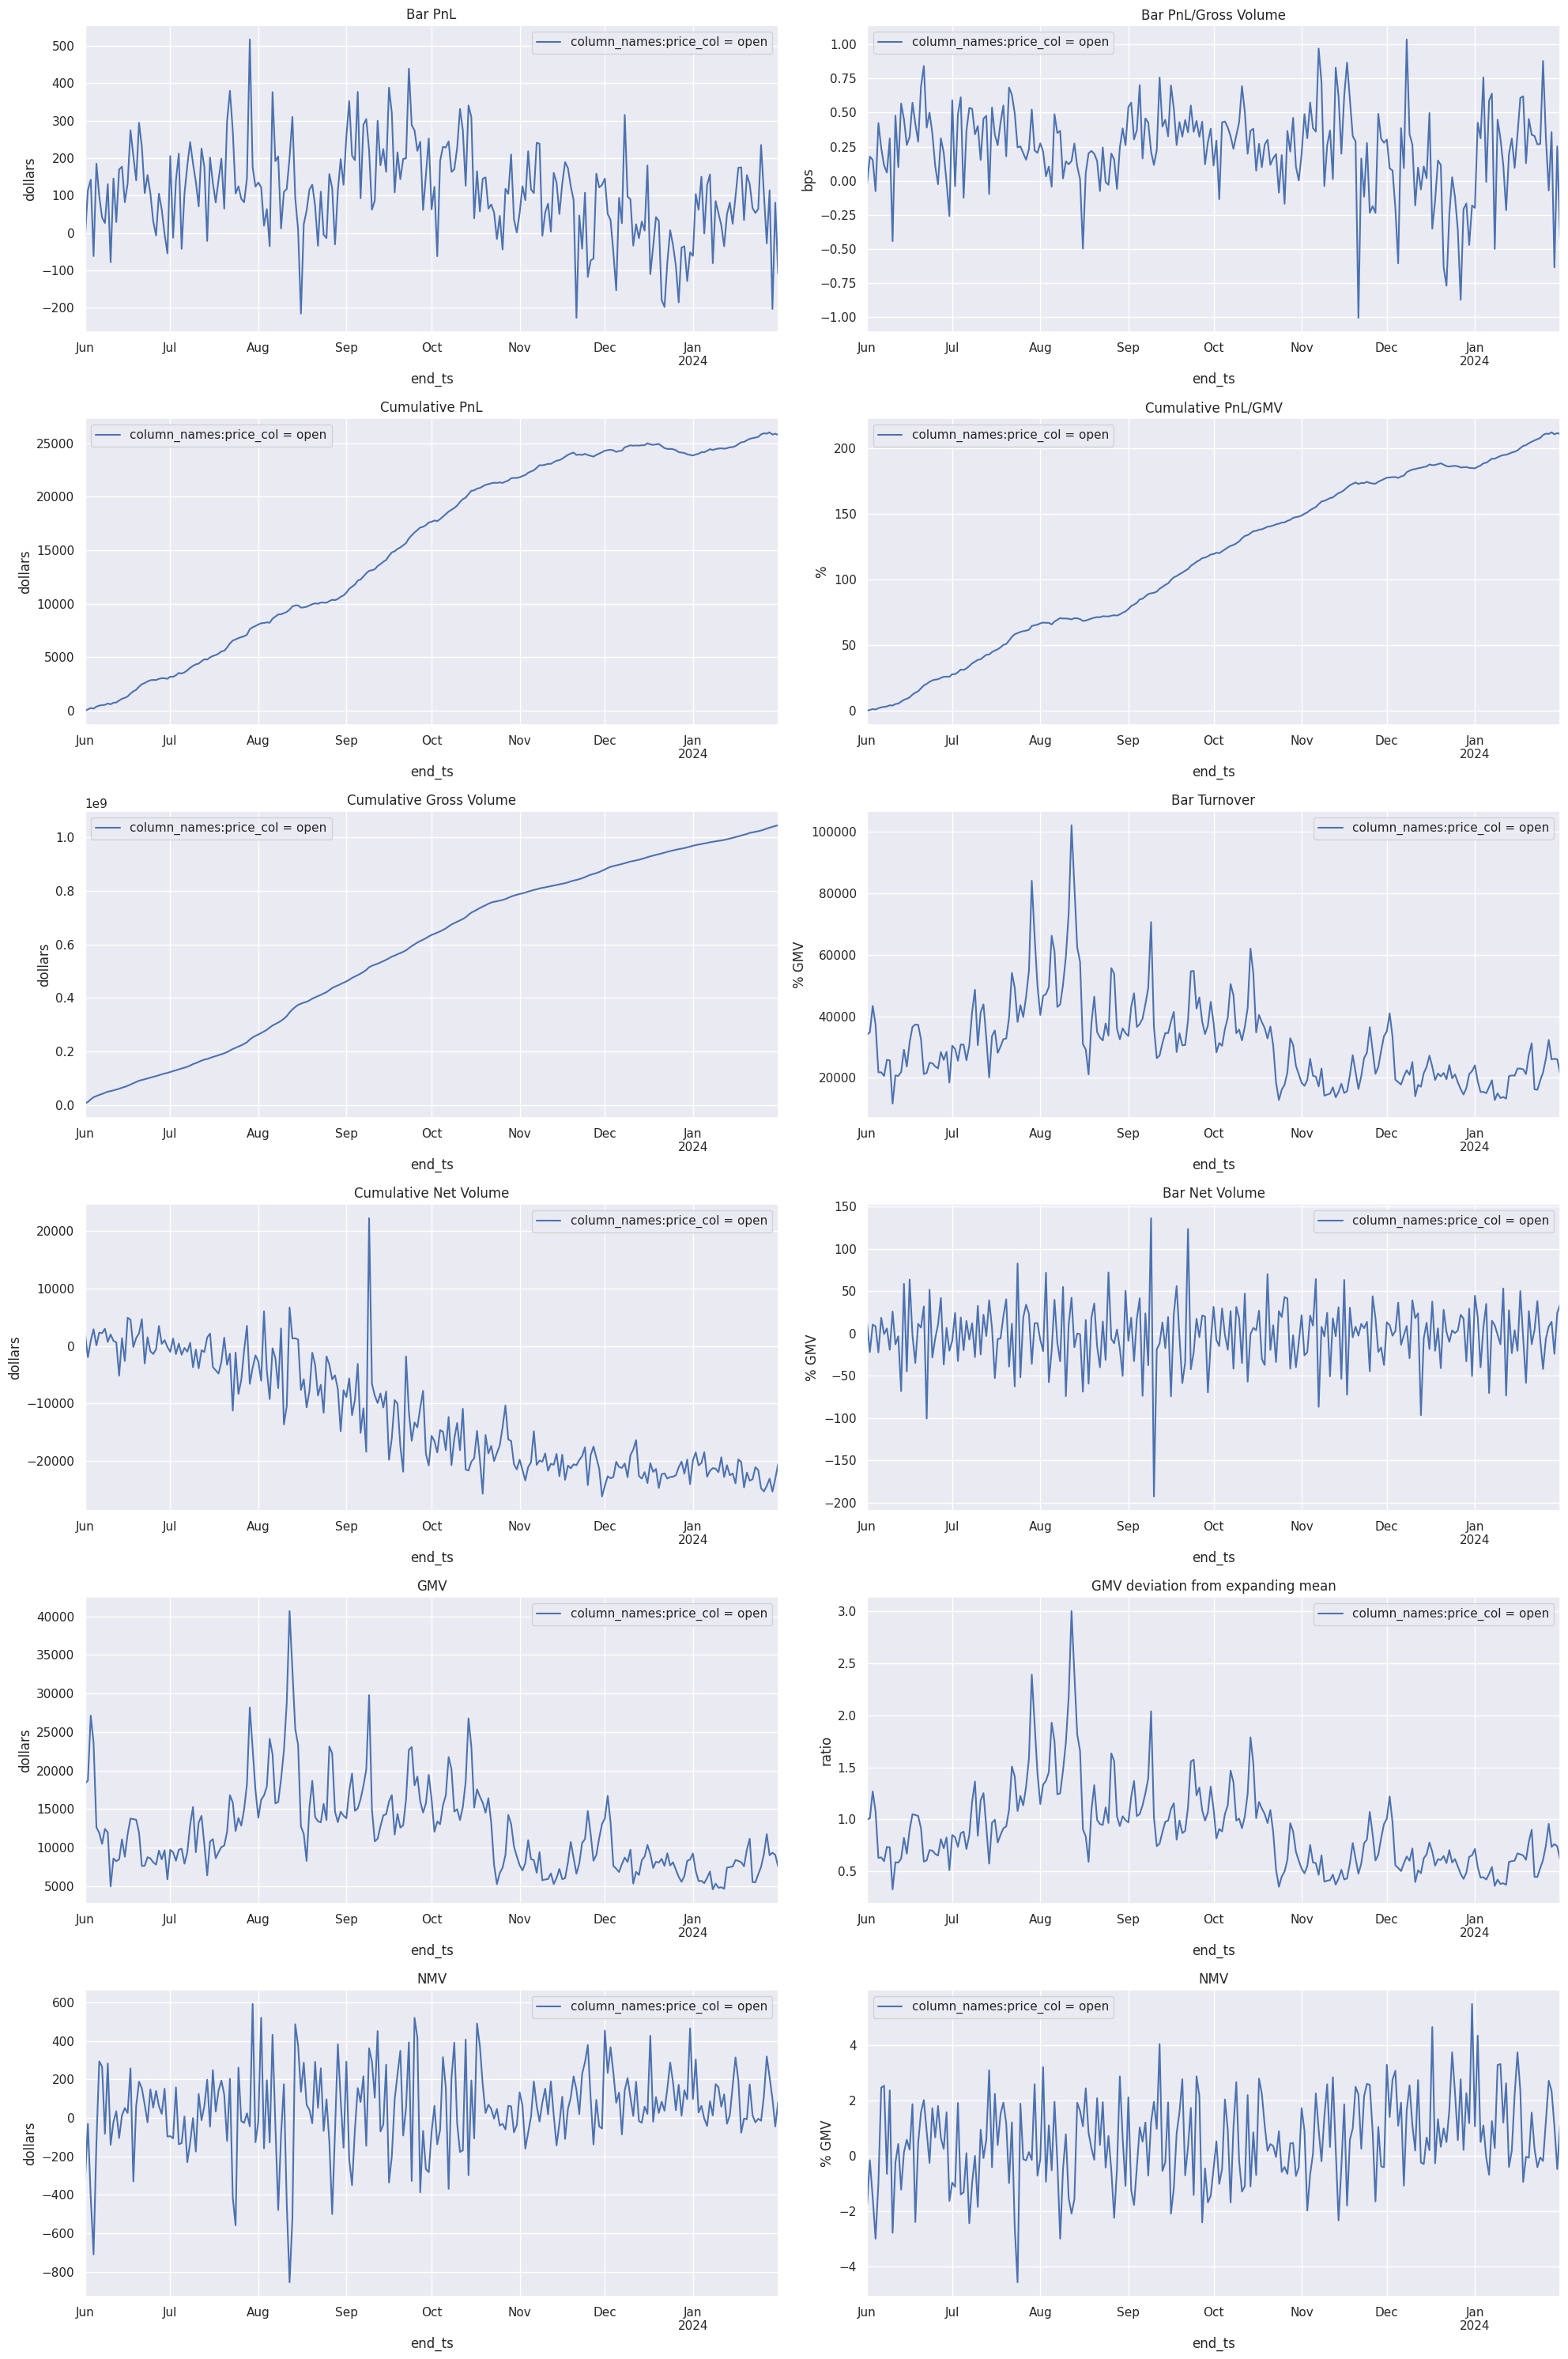

In [15]:
coplotti.plot_portfolio_stats(
    portfolio_stats_df, freq=default_config["pnl_resampling_frequency"]
)

,pnl,pnl_in_bps,sgn_corr,corr
prediction,,,,
"(-inf, -0.842]",0.040519,0.513405,0.020705,0.032645
"(-0.842, -0.253]",0.016405,-0.001055,0.000656,0.012898
"(-0.253, 0.253]",0.000000,0.000000,0.000000,0.000000
"(0.253, 0.842]",0.018059,0.449712,0.018218,0.014154
"(0.842, inf]",0.030166,0.472137,0.017824,0.024145


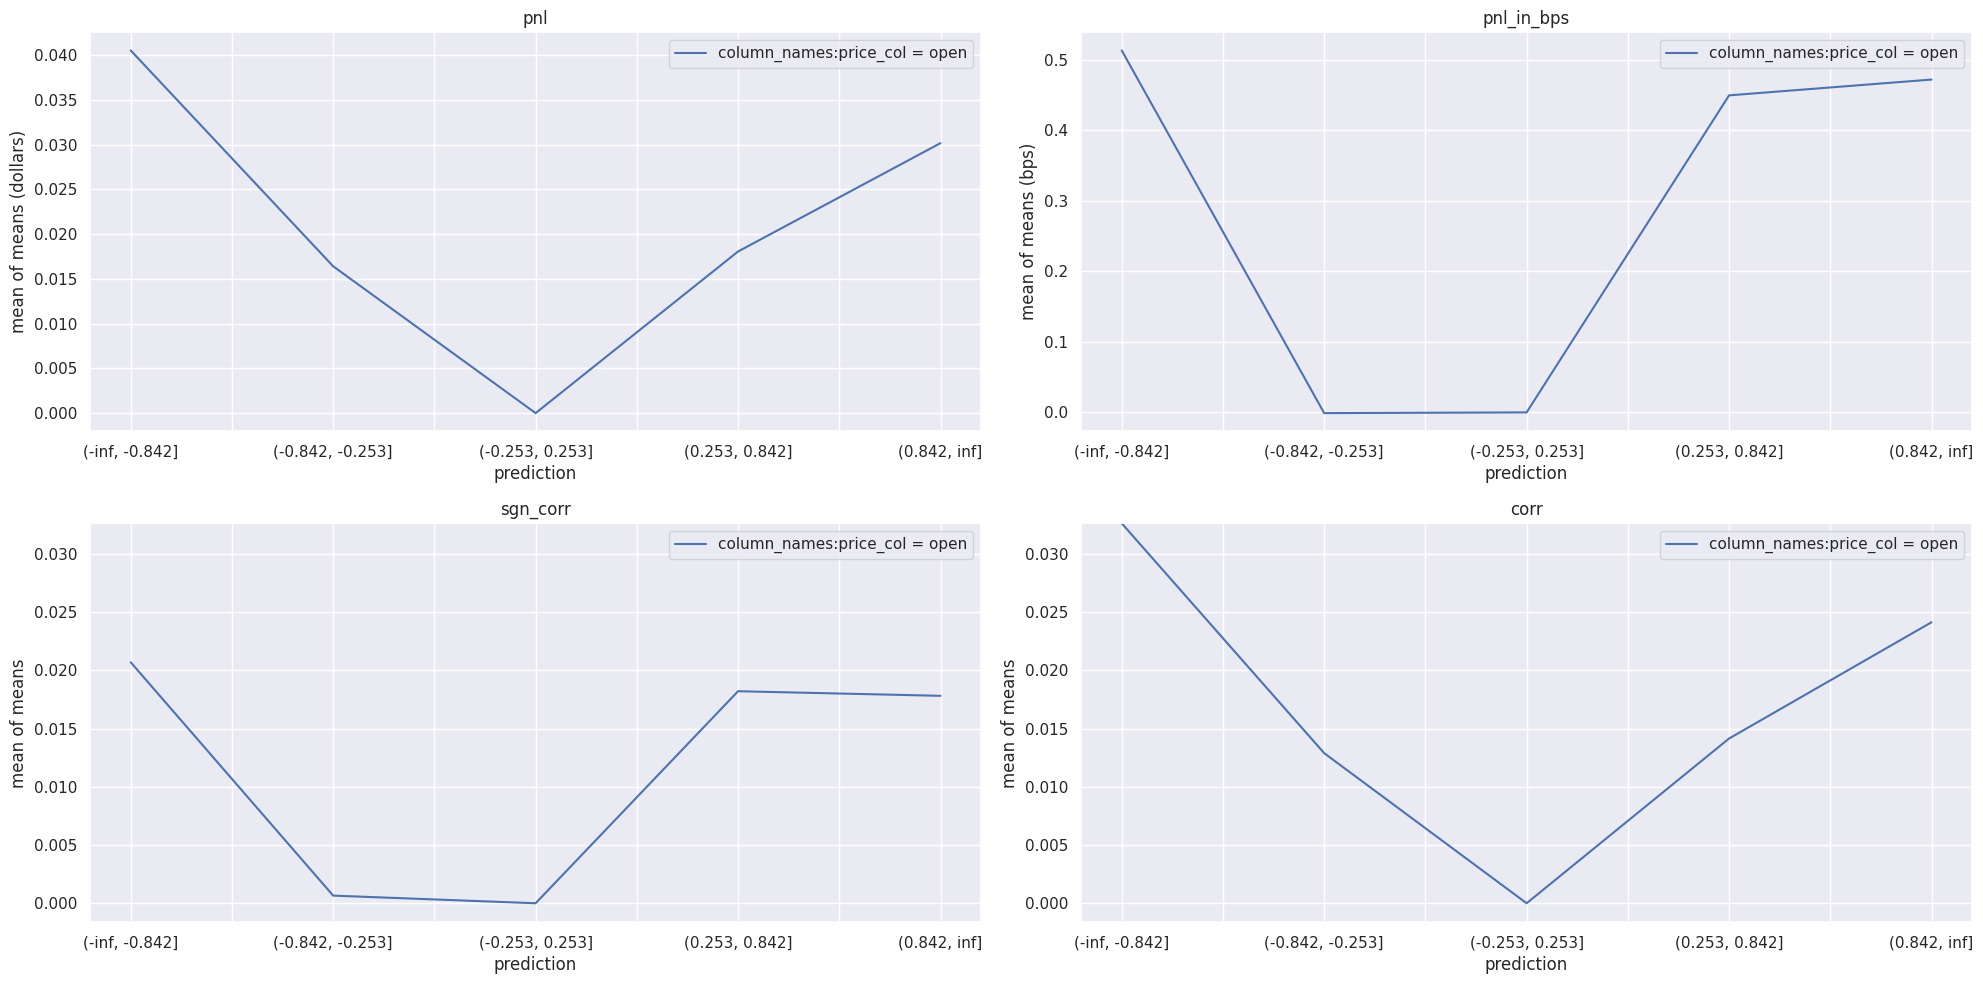

In [16]:
coplotti.plot_portfolio_binned_stats(
    portfolio_df_dict,
    **config["bin_annotated_portfolio_df_kwargs"],
)

# Compute aggregate portfolio stats

In [17]:
stats_computer = dtfmod.StatsComputer()

In [18]:
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    portfolio_stats_df,
    default_config["pnl_resampling_frequency"],
)
display(portfolio_stats)

column_names:price_col = open
ratios     sharpe_ratio                                         16.45
           sharpe_ratio_standard_error                           1.43
           sr.tval                                              13.47
           sr.pval                                               0.00
           kratio                                                5.21
dollar     gmv_mean                                          12225.57
           gmv_stdev                                          5680.06
           annualized_mean_return                            38434.58
           annualized_volatility                              2336.48
           max_drawdown                                       1148.13
           pnl_mean                                            105.23
           pnl_std                                             122.26
           turnover_mean                                   4263806.66
           turnover_stdev                                  1947158.85
           market_bias_mean                                     48.00
           market_bias_stdev                                   214.45
percentage annualized_mean_return                              314.38
           annualized_volatility                                19.11
           max_drawdown                                          9.39
           pnl_mean                                              0.86
           pnl_std                                               1.00
           turnover_mean                                     34876.15
           turnover_stdev                                    15926.94
           market_bias_mean                                      0.39
           market_bias_stdev                                     1.75